# Random Forest Model:
@elivic734, @milli2908

This notebook demonstrates the workflow for building, tuning, and evaluating a Random Forest model for phage gene classification. We tried to optimize the model on the 80/20 split (we also tried other splits, but they perfomed even worse), through paramter tuning and feature importance analysis. The model with the best accuracy and cv-score to date can be found in the first code cell. Underneath you can find code we used to analize and optimize the model. The structure is as follows:

1. **"Best" Model**
2. **Hyperparameter Tuning**
    - RandomizedSearchCV (broad search)
    - GridSearchCV (fine-tuning)
3. **Visualization of Feature Importance**
4. **Finding best number of Features**

---


In [181]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

## 1. "Best" Model

In [182]:
# --- Data loading and preprocessing ---
train_df = pd.read_csv('../data/combined-data-stratified-split/train_data.tsv', sep='\t')
test_df = pd.read_csv('../data/combined-data-stratified-split/test_data.tsv', sep='\t')

# Columns to drop
cols_to_drop = ['Unnamed: 0', 'Geneid', 'DNASequence', 'classification_y']

# Separate features and target variable
X_train_all_features = train_df.drop(columns=cols_to_drop + ['classification_x'], errors='ignore')
y_train = train_df['classification_x']

X_test_all_features = test_df.drop(columns=cols_to_drop + ['classification_x'], errors='ignore')
y_test = test_df['classification_x']

# --- Train a temporary model to get feature importances ---
rf_model_all_features = RandomForestClassifier(
    random_state=42,
    n_estimators=389,
    max_depth=13,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    criterion='gini',
    class_weight='balanced_subsample'
)
rf_model_all_features.fit(X_train_all_features, y_train)

# --- Select top 36 features based on importance ---
importances = rf_model_all_features.feature_importances_
feature_names = X_train_all_features.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
top36_features = feat_imp.index[:36].tolist()
print("Top 36 Features:", top36_features)

# --- Reduce datasets to top 36 features only ---
X_train = X_train_all_features[top36_features]
X_test = X_test_all_features[top36_features]

# --- Retrain model using only top 36 features ---
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=389,
    max_depth=13,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    criterion='gini',
    class_weight='balanced_subsample'
)
rf_model.fit(X_train, y_train)

# --- Model evaluation ---
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

# Cross-validation on training data
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print("CV-Score (mean):", cv_scores.mean())
print("CV-Scores (per fold):", cv_scores)

# Classification report on test data
print(classification_report(y_test, y_pred))


Top 36 Features: ['Gene_Position_Relative', 'kmer_TGA', 'kmer_ATA', 'kmer_TTG', 'GC_Content', 'Seq_length', 'G_Content', 'C_Content', 'kmer_ACA', 'molecular_weight', 'kmer_ATG', 'kmer_TAT', 'seq_length', 'T_Content', 'kmer_GTT', 'kmer_TGG', 'kmer_TAG', 'kmer_TCT', 'kmer_CTG', 'A_Content', 'kmer_GAC', 'aromaticity', 'kmer_AAT', 'C_frac', 'kmer_CCG', 'kmer_CCC', 'kmer_AGA', 'kmer_TAA', 'kmer_GGC', 'GRAVY', 'kmer_AGC', 'kmer_TCA', 'kmer_GTA', 'kmer_CAT', 'kmer_TAC', 'kmer_CAC']
Accuracy: 0.683982683982684
CV-Score (mean): 0.6641421856639248
CV-Scores (per fold): [0.65405405 0.64324324 0.69189189 0.69021739 0.64130435]
              precision    recall  f1-score   support

       early       0.67      0.61      0.64        61
        late       0.70      0.75      0.72        92
      middle       0.68      0.67      0.67        78

    accuracy                           0.68       231
   macro avg       0.68      0.67      0.68       231
weighted avg       0.68      0.68      0.68       2

## 2.1.  Hyperparameter Tuning: RandomSearchCV

In [183]:
# --- Hyperparameter tuning with RandomizedSearchCV ---

param_dist = {
    'n_estimators': [50, 100, 150, 200, 300, 340, 350, 360, 400, 500],
    'max_depth': [None, 5, 10, 20, 30, 40, 35, 45],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'max_leaf_nodes': [None, 10, 20, 50, 100],
    'min_impurity_decrease': [0.0, 0.01, 0.05],
    'oob_score': [False, True],
    'ccp_alpha': [0.0, 0.01, 0.1]
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print('Best parameters found:')
print(random_search.best_params_)

y_pred_best = random_search.predict(X_test)
print('Accuracy (best RF):', accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, ccp_alpha=0.0, class_weight=balanced, criterion=entropy, max_depth=35, max_features=log2, max_leaf_nodes=50, min_impurity_decrease=0.01, min_samples_leaf=2, min_samples_split=4, n_estimators=300, oob_score=False; total time=   1.9s
[CV] END bootstrap=False, ccp_alpha=0.0, class_weight=balanced, criterion=entropy, max_depth=35, max_features=log2, max_leaf_nodes=50, min_impurity_decrease=0.01, min_samples_leaf=2, min_samples_split=4, n_estimators=300, oob_score=False; total time=   1.9s
[CV] END bootstrap=False, ccp_alpha=0.0, class_weight=balanced, criterion=entropy, max_depth=35, max_features=log2, max_leaf_nodes=50, min_impurity_decrease=0.01, min_samples_leaf=2, min_samples_split=4, n_estimators=300, oob_score=False; total time=   1.9s
[CV] END bootstrap=False, ccp_alpha=0.1, class_weight=balanced, criterion=log_loss, max_depth=None, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0

/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
215 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/base.py", line 1356, in wrapper
    estimator._validate_params()
  File "/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/base.py", line 469, in _validate_params
    v

Best parameters found:
{'oob_score': False, 'n_estimators': 340, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 100, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced', 'ccp_alpha': 0.0, 'bootstrap': False}
Accuracy (best RF): 0.6666666666666666
              precision    recall  f1-score   support

       early       0.62      0.66      0.63        61
        late       0.70      0.67      0.69        92
      middle       0.67      0.67      0.67        78

    accuracy                           0.67       231
   macro avg       0.66      0.67      0.66       231
weighted avg       0.67      0.67      0.67       231



## 2.2.  Hyperparameter Tuning: GridSearchCV

In [184]:
# --- Hyperparameter tuning with GridSearchCV ---

param_grid = {
    'n_estimators': [389],
    'max_depth': [13],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'criterion': ['gini'],
    'class_weight': ['balanced_subsample']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='balanced_accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print('Best parameters:', grid_search.best_params_)
print('Best CV score:', grid_search.best_score_)

y_pred_grid = grid_search.predict(X_test)
print('Test set accuracy:', accuracy_score(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   1.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   1.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   1.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   1.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   1.8s
Best parameters:

## 3. Visualization of Feature Importance

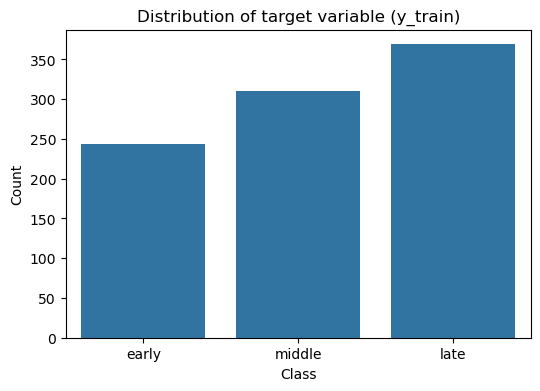

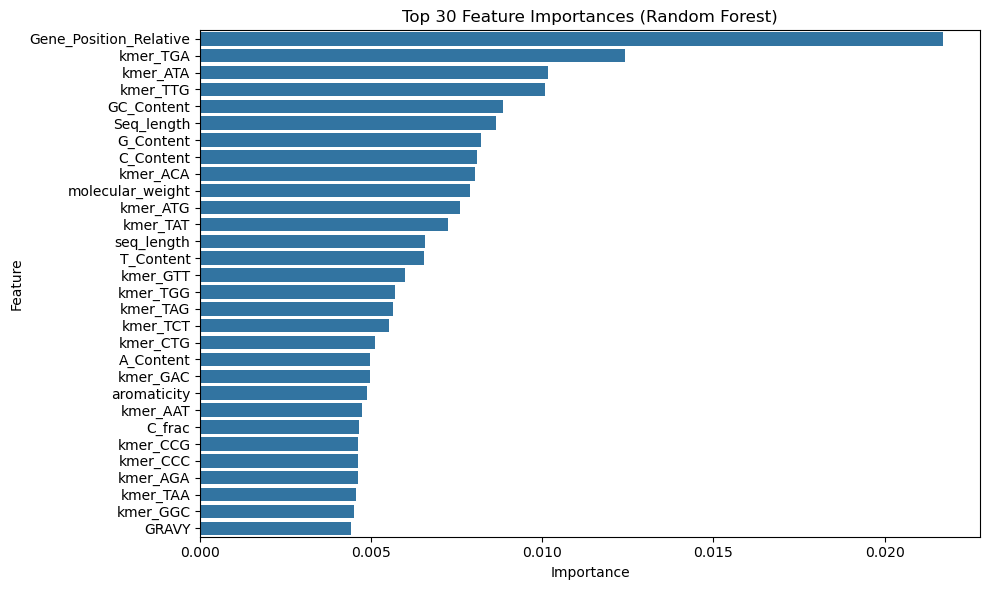

In [185]:
# --- Visualization: target distribution and feature importances ---

# Visualize target variable (y_train) distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title('Distribution of target variable (y_train)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Visualize feature importances (after training!)
if hasattr(rf_model, 'feature_importances_'):
    importances = rf_model_all_features.feature_importances_
    feature_names = X_train_all_features.columns
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feat_imp.values[:30], y=feat_imp.index[:30])
    plt.title('Top 30 Feature Importances (Random Forest)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print('Feature importances not available for this model.')


## 4. Finding best number of Features

In [186]:
# --- Feature number optimization: loop over top-n features ---
results = []
for n in range(1, 86):  # 1 to 86
    # Choose top-n features
    topn_features = feat_imp.index[:n].tolist()
    X_train_n = X_train_all_features[topn_features]
    X_test_n = X_test_all_features[topn_features]
    
    # GridSearchCV
    param_grid = {
        'n_estimators': [389],
        'max_depth': [13],
        'min_samples_split': [5],
        'min_samples_leaf': [1],
        'max_features': ['sqrt'],
        'bootstrap': [True],
        'criterion': ['gini'],
        'class_weight': ['balanced_subsample']
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='balanced_accuracy', 
        verbose=2,
        n_jobs=-1
    )

    grid_search.fit(X_train_n, y_train)
    score = grid_search.best_score_
    results.append({'n_features': n, 'cv_score': score, 'params': grid_search.best_params_})
    print(f"Top {n} Features: CV-Score = {score:.3f}")

# Show results as DataFrame
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   0.8s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   0.8s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   0.8s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   0.8s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   0.8s
Top 1 Features: 

KeyboardInterrupt: 